In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import keras
from collections import Counter
from datetime import datetime
from keras.preprocessing import sequence

In [21]:
stopwords = set(nltk.corpus.stopwords.words('english'))
def cleantext(string):
    # Remove all punctuation
    string = re.sub(r"'s\b", '', string)
    string = re.sub(r'[^\w\s]', '', string)
    # Make all lowercase
    string = string.lower()
    # remove all stopwords
    string = ' '.join([word for word in string.split() if word not in stopwords])
    # Remove all special characters
    string = re.sub(r'\W+', ' ', string)
    return string
def lemmatize(string):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    string = ' '.join([lemmatizer.lemmatize(word) for word in string.split()])
    return string
def preprocess(obj):
    obj = cleantext(obj)
    obj = lemmatize(obj)
    return obj

In [22]:
data = pd.read_csv('../Datasets/news_data_labelled.csv', encoding='latin-1')

In [23]:
initial_data = data.dropna()
initial_data['Text'] = initial_data['Title'] + ' ' + initial_data['Text']
initial_data['Text'] = initial_data['Text'].apply(preprocess)

/var/folders/b_/r3vv94d920j081nfk44rgzqc0000gn/T/ipykernel_20027/348602656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_data['Text'] = initial_data['Title'] + ' ' + initial_data['Text']
/var/folders/b_/r3vv94d920j081nfk44rgzqc0000gn/T/ipykernel_20027/348602656.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_data['Text'] = initial_data['Text'].apply(preprocess)


In [24]:
# calculate term frequencies for texts, and store in dictionary term_freq
term_freq = {}
for text in initial_data['Text']:
    for word in text.split():
        if word in term_freq:
            term_freq[word] += 1
        else:
            term_freq[word] = 1

In [25]:
initial_data['Text'] = initial_data['Text'].apply(nltk.word_tokenize)
initial_data['Sentiment'] = initial_data['Sentiment'].apply(lambda x: 1 if x == 'positive' else (-1 if x == 'negative' else 0))



/var/folders/b_/r3vv94d920j081nfk44rgzqc0000gn/T/ipykernel_20027/2161908480.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_data['Text'] = initial_data['Text'].apply(nltk.word_tokenize)
/var/folders/b_/r3vv94d920j081nfk44rgzqc0000gn/T/ipykernel_20027/2161908480.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_data['Sentiment'] = initial_data['Sentiment'].apply(lambda x: 1 if x == 'positive' else (-1 if x == 'negative' else 0))


In [26]:
from keras.utils import to_categorical

initial_data["Sentiment"] = initial_data["Sentiment"].map({-1: 0, 0: 1, 1: 2})
one_hot = to_categorical(initial_data["Sentiment"], num_classes=3)
# change sentiment column to one hot
initial_data["Sentiment"] = one_hot.tolist()

/var/folders/b_/r3vv94d920j081nfk44rgzqc0000gn/T/ipykernel_20027/3876706404.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_data["Sentiment"] = initial_data["Sentiment"].map({-1: 0, 0: 1, 1: 2})
/var/folders/b_/r3vv94d920j081nfk44rgzqc0000gn/T/ipykernel_20027/3876706404.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_data["Sentiment"] = one_hot.tolist()


In [27]:
from collections import Counter
all_words = [word for sublist in initial_data['Text'].tolist() for word in sublist]
word_count = Counter(all_words)
vocab_to_int = {word: index+1 for index, (word, _) in enumerate(word_count.items())}
initial_data["Text"] = initial_data["Text"].apply(lambda x: [vocab_to_int[word] for word in x if word in vocab_to_int])

/var/folders/b_/r3vv94d920j081nfk44rgzqc0000gn/T/ipykernel_20027/3808331608.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_data["Text"] = initial_data["Text"].apply(lambda x: [vocab_to_int[word] for word in x if word in vocab_to_int])


In [28]:
initial_data = initial_data[initial_data['Text'].map(len) >= 2]
# truncate the text to 512 words
initial_data['Text'] = initial_data['Text'].apply(lambda x: x[:40])
initial_data.reset_index(drop=True, inplace=True)

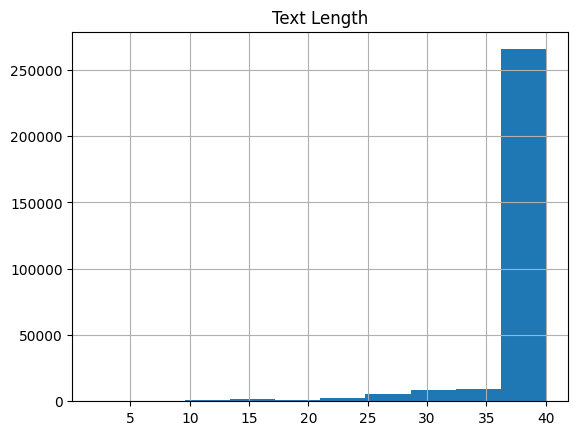

count    295575.000000
mean         38.781101
std           4.033692
min           2.000000
25%          40.000000
50%          40.000000
75%          40.000000
max          40.000000
dtype: float64

In [29]:
text_int = initial_data["Text"].tolist()
sent_length = [len(x) for x in text_int]
plt.title("Text Length")
pd.Series(sent_length).hist()
plt.show()
pd.Series(sent_length).describe()

In [30]:
# postpad the text to 381 words (the 75th percentile)
initial_data["Text"] = list(sequence.pad_sequences(initial_data["Text"], maxlen=750, padding='post'))

In [31]:
initial_data = initial_data[:10000]


In [32]:
from sklearn.model_selection import train_test_split

train_data, temp_data = train_test_split(initial_data, test_size=0.3, random_state=42)

validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [33]:
vocab_size = len(vocab_to_int) + 1
embedding_dim = 256
max_length = 750
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [34]:
model = keras.Sequential([
    keras.layers.Embedding(len(vocab_to_int)+1, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

In [35]:
train_data

,Date,Title,Text,Sentiment
9069,2018-01-08,rugby leaguewidnes papua new guinea centre ott...,"[4453, 74893, 42502, 21, 13534, 6716, 74894, 3...","[0.0, 0.0, 1.0]"
2603,2018-01-03,autos chips retail trader blitz,"[8698, 8679, 2155, 1367, 13711, 8698, 8679, 21...","[0.0, 1.0, 0.0]"
7738,2018-01-08,regulators reject rick perry plan prop coal nu...,"[3615, 6806, 3578, 3213, 1193, 2818, 1116, 405...","[0.0, 0.0, 1.0]"
1579,2018-01-02,klein law firm notifies investors class action...,"[8538, 1538, 685, 25746, 1007, 3216, 801, 1963...","[1.0, 0.0, 0.0]"
5058,2018-01-05,tennis brazil bellucci banned five months doping,"[5125, 3014, 42332, 4196, 550, 54, 16213, 738,...","[1.0, 0.0, 0.0]"
...,...,...,...,...
5734,2018-01-05,hazard states gaining bluestate tax refugees,"[24069, 164, 5709, 6320, 1104, 3078, 111, 121,...","[0.0, 0.0, 1.0]"
5191,2018-01-05,twitter world leader tweet ban policy,"[2353, 40, 72, 7105, 3393, 1237, 2353, 237, 23...","[1.0, 0.0, 0.0]"
5390,2018-01-05,nucor invites join fourth quarter 2017 confere...,"[36674, 20527, 3621, 3051, 1286, 25, 1020, 539...","[0.0, 0.0, 1.0]"
860,2018-01-02,new leadership death compass group ceo,"[21, 1986, 3311, 5615, 335, 2093, 21, 1986, 33...","[1.0, 0.0, 0.0]"


In [36]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 750, 256)          265121280 
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 265294083 (1012.02 MB)
Trainable params: 265294083 (1012.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
epochs = 3

history = model.fit(
    np.array(train_data["Text"].tolist()), 
    np.array(train_data["Sentiment"].tolist()),
    epochs=epochs,
    validation_data=(
        np.array(validation_data["Text"].tolist()),
        np.array(validation_data["Sentiment"].tolist())
    ),
    verbose=1
)

Epoch 1/3
219/219 [==============================] - 551s 3s/step - loss: 0.6852 - accuracy: 0.7277 - val_loss: 0.5684 - val_accuracy: 0.7893
Epoch 2/3
219/219 [==============================] - 538s 2s/step - loss: 0.2966 - accuracy: 0.8906 - val_loss: 0.6331 - val_accuracy: 0.7907
Epoch 3/3
219/219 [==============================] - 537s 2s/step - loss: 0.1067 - accuracy: 0.9653 - val_loss: 0.9544 - val_accuracy: 0.7753


In [38]:
from sklearn.metrics import accuracy_score
predict = model.predict(np.array(test_data["Text"].tolist()))
class_predictions = np.argmax(predict, axis=1)
class_labels = np.argmax(np.array(test_data["Sentiment"].tolist()), axis=1)
acc = accuracy_score(class_labels, class_predictions)
print(acc)

47/47 [==============================] - 8s 169ms/step
0.7866666666666666


# DEMO on CNBC news article

In [39]:
def get_sentiment_value(model, vocab_to_int, text, max_length):
    preprocessed_text = preprocess(text)
    tokenized_text = nltk.word_tokenize(preprocessed_text)

    # maybe change 0 to something for OOV words?
    int_text = [vocab_to_int.get(word, 0) for word in tokenized_text]  

    padded_sequence = keras.preprocessing.sequence.pad_sequences([int_text], maxlen=max_length, padding='post')
    prediction = model.predict(padded_sequence)
    sentiment_value = np.argmax(prediction)
    
    return sentiment_value

In [59]:
article1 = """Stock market news today: US futures gain after CPI meets estimates Tue, December 12, 2023 at 1:42 PM GMT
US stock futures held steady near their 2023 highs on Tuesday as a key inflation report showed prices largely holding steady ahead of the Federal Reserve's final 2023 policy meeting.

Dow Jones Industrial Average (^DJI) futures edged up roughly 0.4%, while S&P 500 (^GSPC) futures rose around 0.3%. Contracts on the tech-heavy Nasdaq 100 (^NDX) rose about 0.5%, after all three major gauges closed Monday at their highest levels since early 2022.

The Consumer Price Index (CPI) showed prices ticked up slightly at 0.1% over last month and 3.1% over the prior year in November, as Yahoo Finance's Alexandra Canal reported.

Investors are widely expecting a pause to rate hikes at the end of the central bank's two-day meeting, which starts Tuesday. But traders are easing back on their bets on a rate cut in March, according to CME FedWatch data.

Read more: What the Fed rate-hike pause means for bank accounts, CDs, loans, and credit cards

While consumer inflation is expected to remain flat for the second straight month, the "core" reading — which excludes food and energy prices — could prove stickier. That would likely prompt investors to rethink when the Fed might start lowering rates.

Ahead of the report, US bond yields retreated, with 10-year Treasury yields (^TNX) down roughly 4 basis points to trade around 4.19%.

In individual stocks, Oracle (ORCL) shares sank over 8% in premarket trading after the software giant's second-quarter sales fell short of estimates.

SNP - Delayed Quote (USD)

4,622.44
+18.07(0.39%)
"""

article2 = """India overtakes Hong Kong to become the world’s seventh largest stock market
Pedestrians walk towards the Chhatrapati Shivaji Terminus train station at dusk in Mumbai, India, on Wednesday, Oct. 4, 2023.
Pedestrians walk towards the Chhatrapati Shivaji Terminus train station at dusk in Mumbai, India, on Wednesday, Oct. 4, 2023.
Bloomberg | Bloomberg | Getty Images
India’s stock market value has overtaken Hong Kong’s to become the seventh largest in the world as optimism about the country’s economic prospects grows.

As of the end of November, the total market capitalization of the National Stock Exchange of India was $3.989 trillion versus Hong Kong’s $3.984 trillion, according to data from the World Federation of Exchanges.

India’s Nifty 50 index reached another record high on Tuesday. It has jumped 16% so far this year and is headed for its eighth straight year of gains. In contrast, Hong Kong’s benchmark Hang Seng index has plunged 17% year to date.

India has been a standout market this year in the Asia-Pacific region. Increased liquidity, more domestic participation and improving dynamics in the global macro environment in the form of falling U.S. Treasury yields have all boosted the country’s stock markets.


NIFTY 50

*Data is delayed | Exchange | INR

The world’s most populous country also heads into general elections next year, which analysts predict could be another victory for the ruling nationalist Bharatiya Janata Party.

“For the general election, opinion polls and recent state elections indicate that the incumbent BJP-led government may secure a decisive win, which could trigger a bull run in the first three to four months of the year on expectations of policy continuity,” HSBC strategists said in a client note.

HSBC said banks, health care and energy are the best positioned sectors for next year.

Sectors such as autos, retailers, real estate and telecoms are also relatively well positioned for 2024, while fast-moving consumer goods, utilities and chemicals are among those HSBC categorized as unfavorable.

Hong Kong lags

Hong Kong’s Hang Seng index is poised to notch a fourth year of declines and is the worst performer among major Asia-Pacific equity markets.

Last week, Moody’s cut its outlook for Hong Kong from stable to negative, citing the city’s financial, political, institutional and economic ties to mainland China. That downgrade came soon after Moody’s reduced its outlook for China’s government credit ratings to negative to stable.

Moody's Hong Kong credit outlook downgrade is not a fair one, says financial secretary
In early November, the Hong Kong government said it expects the economy to grow 3.2% in 2023, trimming its GDP growth outlook from the 4% to 5% forecast in August.

The city’s government has warned that increasing geopolitical tensions and tight financial conditions continue to weigh on investments, exports of goods and consumption sentiment. Consumer confidence has also suffered in Hong Kong.

“Hong Kong’s economy is poised for a soft landing in 2024 as annual real GDP growth moderates to around 2% from 2023′s 3.5%,” said economists at DBS.

“Central to this recovery is mainland tourism revival, fortifying retail and catering sectors.”

China has set a growth target of 5% for 2023. Its third quarter-GDP came in at 4.9%, lifting hopes that the world’s second-largest economy will meet or even exceed expectations.
"""

article3 = """Warren Buffett’s Berkshire Hathaway continues to sell HP shares, reducing stake to 5.2%
Warren Buffett tours the floor ahead of the Berkshire Hathaway Annual Shareholder's Meeting in Omaha, Nebraska.
Warren Buffett’s conglomerate Berkshire Hathaway has reduced its stake in HP to 5.2%, according to a regulatory filing released Monday night.

The conglomerate previously had a nine-day selling streak in mid-September through early October, bringing down the bet on the printer and PC maker to about 10%.

Shares of HP dipped more than 1% in after-hours trading Monday following the news.

Berkshire still owns 51.5 million shares of HP, worth about $1.6 billion based on Monday’s close of $30.37. The Omaha-based investing giant is still the third-largest institutional shareholder of HP, only behind BlackRock and Vanguard, according to FactSet.

Last month, HP issued first-quarter profit guidance that came below Wall Street estimates, according to LSEG, formerly known as Refinitiv. However, the firm kept its full-year earnings outlook, signaling that the demand in the personal computers market could still be recovering.

Berkshire initially bought the tech hardware stock in April 2022. The bet, however, hasn’t been lucrative as the stock is still below the level where it was first bought. Shares are up 13% this year, underperforming the Nasdaq Composite, which has rallied nearly 38%."""

article4 = "negative outlook for the stock market"

article5 = "horrible outlook is bad and terrible"


In [60]:
sentiment_value_1 = get_sentiment_value(model, vocab_to_int, article1, max_length)
sentiment_value_2 = get_sentiment_value(model, vocab_to_int, article2, max_length)
sentiment_value_3 = get_sentiment_value(model, vocab_to_int, article3, max_length)
sentiment_value_4 = get_sentiment_value(model, vocab_to_int, article4, max_length)
sentiment_value_5 = get_sentiment_value(model, vocab_to_int, article5, max_length)

1/1 [==============================] - 0s 70ms/step


In [57]:
label_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}


In [61]:
print(f"The sentiment for article 1 is: {label_mapping[sentiment_value_1]}")
print(f"The sentiment for article 2 is: {label_mapping[sentiment_value_2]}")

# Overfits on positive sentiment data
print(f"The sentiment for article 3 is: {label_mapping[sentiment_value_3]}")
print(f"The sentiment for article 4 is: {label_mapping[sentiment_value_4]}")
print(f"The sentiment for article 5 is: {label_mapping[sentiment_value_5]}")

The sentiment for article 1 is: Positive
The sentiment for article 2 is: Positive
The sentiment for article 3 is: Positive
The sentiment for article 4 is: Neutral
The sentiment for article 5 is: Neutral


Big bias to positives

In [63]:
sentiment_counts = np.sum(np.array(train_data["Sentiment"].tolist()), axis=0)

negative_count = sentiment_counts[0]  
neutral_count = sentiment_counts[1]
positive_count = sentiment_counts[2] 

# Print the counts
print(f"Negative: {negative_count}")
print(f"Neutral: {neutral_count}")
print(f"Positive: {positive_count}")

Negative: 1691.0
Neutral: 823.0
Positive: 4486.0
